In [1]:
# scipy.stats.wilcoxon

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import random

import scipy.stats as stats

In [3]:
df = pd.read_csv('../data/kandidater_data.csv').dropna()

In [4]:
# gender dummy question
df['26'] = df["Gender"].map(lambda x: -2 if x == "M" else 2) # random.choices([2, -2], weights=[0.5, 0.5])[0]

# age dummy question
df['Age'] = 2022 - df.Birthdate.str[:4].astype(int)
df['27'] = df['Age'].map(lambda x: 0 if x <= 30 else 2)

# block dummy question
blok_dict = {
    'A': 1,
    'Ø': 1,
    'F': 1,
    'Å': 1,
    'Q': 1,
    'V': 0,
    'C': 0,
    'O': 0,
    'I': 0,
    'Æ': 0,
    'D': 0,
    # ikke så rød-blå
    'B': 1,
    'M': 0,
    'K': 0
}

df['Block'] = df.CurrentPartyCode.map(blok_dict)
df['28'] = df.Block.apply(lambda x: 0 if x==1 else 2)

# education dummy variable
edu_map = {
    'Grundskole': 1,
    '10. klasse': 2,
    'Erhvervsuddannelse': 4,
    'Gymnasial uddannelse': 4,
    'Seminaruddannelse': 6,
    'Bachelor-/diplomuddannelse': 6,
    'Kandidat-/masteruddannelse': 7,
    'Ph.d-uddannelse': 8
}
df['EducationLevel'] = df.Education.map(edu_map)
df['29'] = df.EducationLevel.apply(lambda x: -2 if x >= 6 else 2)

# Profession
political_professions = {
    'Folketingsmedlem' : True,
     'Minister' : True,
     'Ikke oplyst' : False,
     'Offentligt ansat' : False,
     'Byråds- eller regionsrådsmedlem' : True,
     'Privat ansat/selvstændig' : False,
     'Studerende' : False,
     'Leder' : False,
     'Ordfører for et parti' : True,
     'Udenfor arbejdsmarkedet' : False,
     'Partileder' : True,
     'Europa-Parlamentariker' : True,
}

df["IsPolitical"] = df["Profession"].map(political_professions)
df['30'] = df.IsPolitical.apply(lambda x: -2 if x else 2)

In [5]:
n_questions = 30

In [6]:
def propensity(df, y, onehotvars=[], minmaxvars=[]):
    clf = LogisticRegression()

    ct = ColumnTransformer([
        ('scaler', MinMaxScaler(), minmaxvars),
        ('one hot', OneHotEncoder(), onehotvars)
    ])

    pipe = Pipeline([
        ('column transformer', ct), 
        ('logistic reg', clf)
    ])
    
    pipe.fit(df, y)
    df['propensity'] = pipe.predict_proba(df)[:, 1]

In [7]:
def match(df1, df2):
    x = df1.propensity.to_numpy().reshape(-1, 1)
    y = df2.propensity.to_numpy().reshape(-1, 1)
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(x)
    _, idx = nn.kneighbors(y)
    return df1.iloc[idx.reshape(-1)], df2

In [8]:
def match2(df1, df2):
    x = df2.propensity.to_numpy().reshape(-1, 1)
    y = df1.propensity.to_numpy().reshape(-1, 1)
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(x)
    _, idx = nn.kneighbors(y)
    return df2.iloc[idx.reshape(-1)], df1

In [9]:
params = {
    'onehotvars': ['CurrentPartyCode', 'Profession', 'Education', 'Gender']
    # 'minmaxvars': ['Age']
}

In [10]:
y = df['Age'].map(lambda x: 1 if x<=30 else 0).to_numpy()
propensity(df, y, **params)

In [11]:
mask = df.Age <= 30
df1 = df[mask]
df2 = df[~mask]

In [12]:
df1, df2 = match(df1, df2)

In [13]:
_, p_values = stats.ttest_rel(df1[[str(i) for i in range(1, 31)]], df2[[str(i) for i in range(1, 31)]])

<ipython-input-13-78183864cdcb>:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_values = stats.ttest_rel(df1[[str(i) for i in range(1, 31)]], df2[[str(i) for i in range(1, 31)]])


In [14]:
np.where(p_values <= 0.002)[0] + 1

array([ 6, 12, 15, 17, 21, 22, 23, 25, 27], dtype=int64)

In [15]:
_, p_values = stats.wilcoxon(df1[[str(i) for i in range(1, 31)]], df2[[str(i) for i in range(1, 31)]])

In [16]:
np.where(p_values <= 0.002)[0] + 1

array([ 6, 15, 17, 21, 22, 23, 25, 27], dtype=int64)

In [17]:
plt.style.use('ggplot')

In [33]:
params = {
    'alpha': .7,
    'width': .33,
    'edgecolor': 'black'
}

gridspec_params = {
    'hspace': 0.1
}

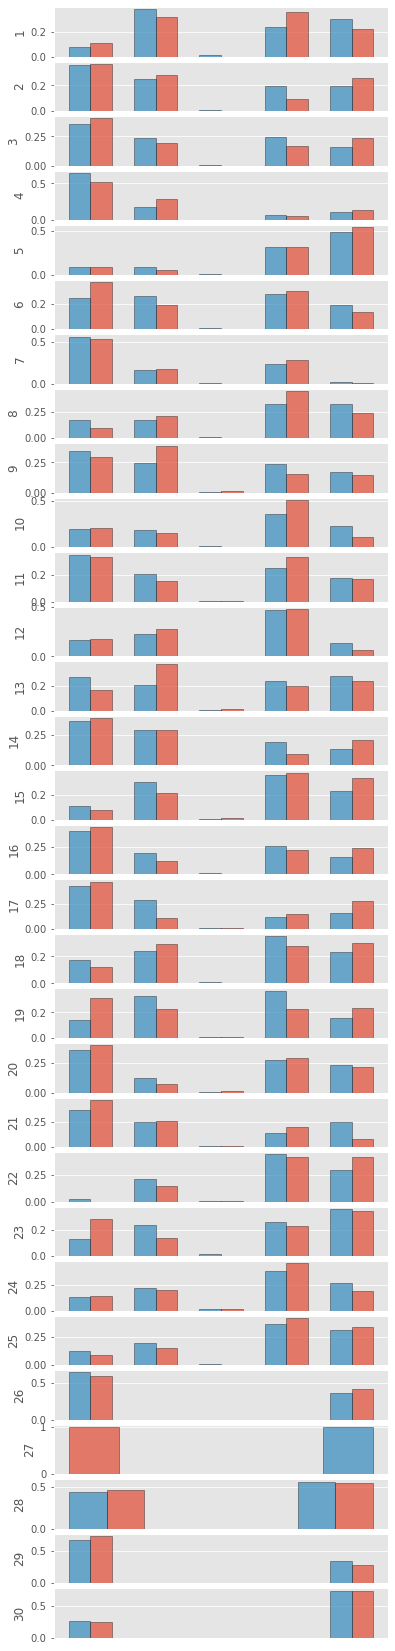

In [34]:
fig, axes = plt.subplots(n_questions, figsize=(6, 30), gridspec_kw=gridspec_params)

for i in range(n_questions):
    ax = axes[i]
    x, y = np.unique(df1[str(i+1)], return_counts=True)
    y = y / y.sum()
    ax.bar(x+params['width']/2, y, **params)

    x, y = np.unique(df2[str(i+1)], return_counts=True)
    y = y / y.sum()
    ax.bar(x-params['width']/2, y, **params)
    
    ax.set_xticks([])
    # ax.set_ylim(0, 1)
    ax.set_ylabel(str(i+1))
    

In [35]:
params = {
    'alpha': .7
}

gridspec_params = {
    'hspace': 0.1
}

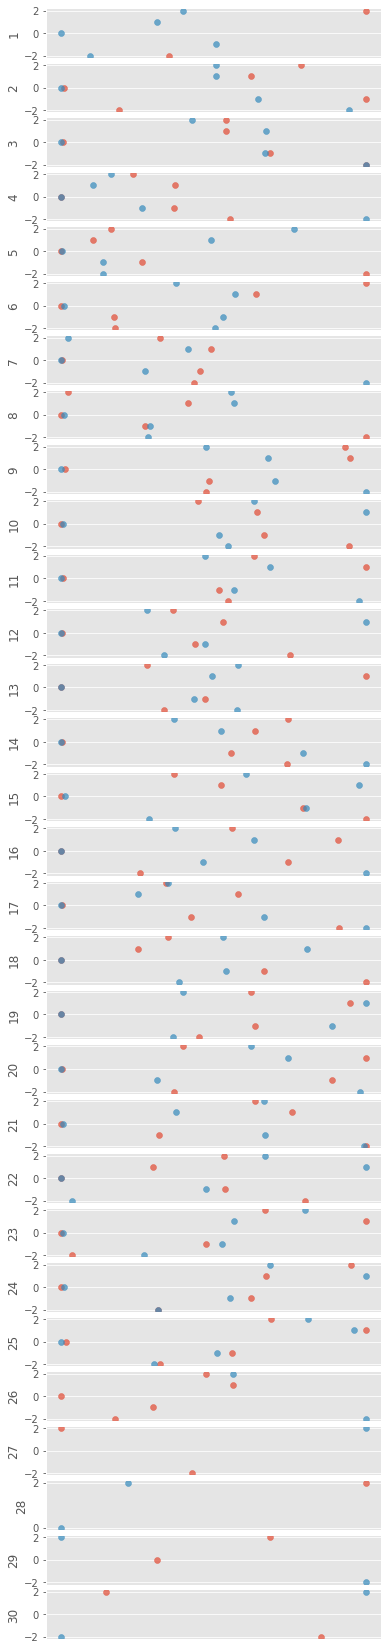

In [45]:
fig, axes = plt.subplots(n_questions, figsize=(6, 30), gridspec_kw=gridspec_params)

for i in range(n_questions):
    ax = axes[i]
    x1, y1 = np.unique(df1[str(i+1)], return_counts=True)
    y1 = y1 / y1.sum()
    ax.scatter(y2, x2, **params)

    x2, y2 = np.unique(df2[str(i+1)], return_counts=True)
    y2 = y2 / y2.sum()
    ax.scatter(y2, x2, **params)
    
    ax.set_xticks([])
    # ax.set_ylim(0, 1)
    ax.set_ylabel(str(i+1))

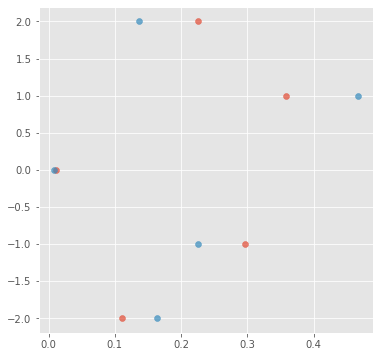

In [66]:
fig, ax = plt.subplots(figsize=(6, 6), gridspec_kw=gridspec_params)

q = '12'

x1, y1 = np.unique(df1[q], return_counts=True)
y1 = y1 / y1.sum()
ax.scatter(y2, x2, **params)

x2, y2 = np.unique(df2[q], return_counts=True)
y2 = y2 / y2.sum()
ax.scatter(y2, x2, **params)
